# Credit Card Lead Prediction
-----------
## Problem Statement

Happy Customer Bank is a mid-sized private bank that deals in all kinds of banking products, like Savings accounts, Current accounts, investment products, credit products, among other offerings. The bank also cross-sells products to its existing customers and to do so they use different kinds of communication like tele-calling, e-mails, recommendations on net banking, mobile banking, etc. In this case, the Happy Customer Bank wants to cross sell its credit cards to its existing customers. The bank has identified a set of customers that are eligible for taking these credit cards.

Now, the bank is looking for your help in identifying customers that could show higher intent towards a recommended credit card, given:
* Customer details (gender, age, region etc.)
* Details of his/her relationship with the bank (Channel_Code,Vintage, 'Avg_Asset_Value etc.)

**Link:** https://datahack.analyticsvidhya.com/contest/job-a-thon-2/?utm_source=sendinblue&utm_campaign=JobAThon__Now_Live__Registrations__05282021&utm_medium=email#LeaderBoard

## Evaluation
The evaluation metric for this competition is `roc_auc_score` across all entries in the test set.

## Environment Setup

In [ ]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE

!pip install catboost
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
import lightgbm as lgb

## Dataset

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/train_s3TEQDk.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/test_mSzZ8RL.csv')

In [ ]:
train_df.describe()

,Age,Vintage,Avg_Account_Balance,Is_Lead
count,245725.000000,245725.000000,2.457250e+05,245725.000000
mean,43.856307,46.959141,1.128403e+06,0.237208
std,14.828672,32.353136,8.529364e+05,0.425372
min,23.000000,7.000000,2.079000e+04,0.000000
25%,30.000000,20.000000,6.043100e+05,0.000000
50%,43.000000,32.000000,8.946010e+05,0.000000
75%,54.000000,73.000000,1.366666e+06,0.000000
max,85.000000,135.000000,1.035201e+07,1.000000


In [ ]:
test_df.describe()

,Age,Vintage,Avg_Account_Balance
count,105312.000000,105312.000000,1.053120e+05
mean,43.871002,46.842819,1.134195e+06
std,14.872890,32.273634,8.662430e+05
min,24.000000,7.000000,2.259700e+04
25%,30.000000,20.000000,6.039822e+05
50%,43.000000,32.000000,8.966345e+05
75%,54.000000,73.000000,1.371598e+06
max,85.000000,135.000000,9.908858e+06


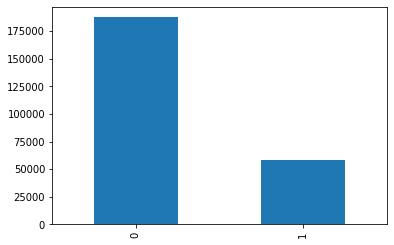

In [ ]:
train_df['Is_Lead'].value_counts().plot(kind='bar')

# Clearly demonstrates the fact that there is class imbalance

## Data Preprocessing

### Filling Null Values

In [ ]:
train_df['Credit_Product'] = train_df['Credit_Product'].fillna(train_df['Credit_Product'].mode()[0])
test_df['Credit_Product'] = test_df['Credit_Product'].fillna(test_df['Credit_Product'].mode()[0])

In [ ]:
train_df['Avg_Account_Balance'] = np.log(train_df['Avg_Account_Balance'])
test_df['Avg_Account_Balance'] = np.log(test_df['Avg_Account_Balance'])

In [ ]:
test_id = test_df['ID']

# Dropping columns
train_df.drop('ID', axis=1, inplace=True)
test_df.drop('ID', axis=1, inplace=True)

X = train_df.drop('Is_Lead', axis=1)
y = train_df['Is_Lead']

### Encoding and Scaling the data

In [ ]:
# Separating categorical and numerical columns
categorical_cols = []
numerical_cols = []

for label, content in X.items():
    if pd.api.types.is_string_dtype(content):
        categorical_cols.append(label)
    else:
        numerical_cols.append(label)

In [ ]:
categorical_cols

['Gender',
 'Region_Code',
 'Occupation',
 'Channel_Code',
 'Credit_Product',
 'Is_Active']

In [ ]:
numerical_cols

['Age', 'Vintage', 'Avg_Account_Balance']

In [ ]:
# Encoding labels
label_encoder = LabelEncoder()
for col in categorical_cols:
  lab_fit = label_encoder.fit(X[col])
  X[col] = lab_fit.transform(X[col])
  test_df[col] = lab_fit.transform(test_df[col])

minmax_scaler = MinMaxScaler()
minmax_fit = minmax_scaler.fit(X[numerical_cols])
X[numerical_cols] = minmax_fit.transform(X[numerical_cols])
test_df[numerical_cols] = minmax_fit.transform(test_df[numerical_cols])

In [ ]:
X.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,0,0.806452,18,1,2,0.281250,0,0.630865,0
1,0,0.112903,27,2,0,0.195312,0,0.536510,0
2,0,0.532258,18,3,2,0.148438,0,0.687265,1
3,1,0.177419,20,2,0,0.093750,0,0.502253,0
4,0,0.112903,32,2,0,0.203125,0,0.604324,0


In [ ]:
test_df.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,1,0.096774,4,1,0,0.140625,1,0.575701,0
1,1,0.322581,18,1,1,0.328125,0,0.611211,0
2,1,0.129032,20,2,0,0.054688,0,0.376875,0
3,1,0.096774,22,1,0,0.203125,0,0.600889,0
4,0,0.096774,20,1,0,0.093750,0,0.556053,0


Handling class imbalance problem

In [ ]:
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

## Model Experimentation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [ ]:
def _model_experimentation(models, X_train, X_test, y_train, y_test):
    '''
    Fit and Score the deep learning models without performing hyperparameter tuning
    '''
    train_scores = {}
    test_scores = {}
    for name, model in models.items():
      model.fit(X_train, y_train)
      train_pred = model.predict_proba(X_train)[:,1]
      test_pred = model.predict_proba(X_test)[:,1]
      train_scores[name] = roc_auc_score(y_train, train_pred)
      test_scores[name] = roc_auc_score(y_test, test_pred)
    return train_scores, test_scores

In [ ]:
deep_models = {'XGB': xgb.XGBClassifier(n_jobs=-1),
               'CAT': CatBoostClassifier(),
               'ADA': AdaBoostClassifier(),
               'GBR': GradientBoostingClassifier(),
               'LGB': lgb.LGBMClassifier(),
               'RF': RandomForestClassifier()
              }

In [ ]:
train_score_1, test_score_1 = _model_experimentation(deep_models, X_train, X_test, y_train, y_test)

Learning rate set to 0.111132
0:	learn: 0.6686525	total: 95.4ms	remaining: 1m 35s
1:	learn: 0.6496618	total: 186ms	remaining: 1m 33s
2:	learn: 0.6339529	total: 269ms	remaining: 1m 29s
3:	learn: 0.6177368	total: 359ms	remaining: 1m 29s
4:	learn: 0.6074858	total: 450ms	remaining: 1m 29s
5:	learn: 0.5999715	total: 540ms	remaining: 1m 29s
6:	learn: 0.5887829	total: 630ms	remaining: 1m 29s
7:	learn: 0.5830344	total: 726ms	remaining: 1m 30s
8:	learn: 0.5788308	total: 817ms	remaining: 1m 30s
9:	learn: 0.5690473	total: 908ms	remaining: 1m 29s
10:	learn: 0.5583598	total: 1.01s	remaining: 1m 30s
11:	learn: 0.5532796	total: 1.1s	remaining: 1m 30s
12:	learn: 0.5486517	total: 1.2s	remaining: 1m 31s
13:	learn: 0.5423396	total: 1.29s	remaining: 1m 30s
14:	learn: 0.5367121	total: 1.38s	remaining: 1m 30s
15:	learn: 0.5325986	total: 1.47s	remaining: 1m 30s
16:	learn: 0.5282340	total: 1.56s	remaining: 1m 30s
17:	learn: 0.5244727	total: 1.67s	remaining: 1m 30s
18:	learn: 0.5225348	total: 1.75s	remaining: 

In [ ]:
train_score_1

{'ADA': 0.7897546272546578,
 'CAT': 0.9396085444145096,
 'GBR': 0.8569766272050624,
 'LGB': 0.9260874410392957,
 'RF': 0.999999999448152,
 'XGB': 0.8613771672809958}

In [ ]:
xgb_model = xgb.XGBClassifier(n_jobs=-1)
xgb_model.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
test_score_1

{'ADA': 0.7882823693515572,
 'CAT': 0.9307207250411387,
 'GBR': 0.855405657844626,
 'LGB': 0.924587132732717,
 'RF': 0.9222050059389472,
 'XGB': 0.8596949546462727}

In [ ]:
cat_model = CatBoostClassifier()
mean_score = cross_val_score(cat_model, X, y, scoring="roc_auc", cv = 10).mean()

Streaming output truncated to the last 5000 lines.
0:	learn: 0.6663009	total: 113ms	remaining: 1m 52s
1:	learn: 0.6458177	total: 225ms	remaining: 1m 52s
2:	learn: 0.6295562	total: 337ms	remaining: 1m 51s
3:	learn: 0.6124023	total: 472ms	remaining: 1m 57s
4:	learn: 0.6007264	total: 586ms	remaining: 1m 56s
5:	learn: 0.5929176	total: 710ms	remaining: 1m 57s
6:	learn: 0.5863717	total: 836ms	remaining: 1m 58s
7:	learn: 0.5775677	total: 966ms	remaining: 1m 59s
8:	learn: 0.5670904	total: 1.09s	remaining: 2m
9:	learn: 0.5627904	total: 1.23s	remaining: 2m 1s
10:	learn: 0.5590442	total: 1.34s	remaining: 2m
11:	learn: 0.5547708	total: 1.47s	remaining: 2m
12:	learn: 0.5475178	total: 1.58s	remaining: 2m
13:	learn: 0.5432278	total: 1.71s	remaining: 2m
14:	learn: 0.5374393	total: 1.84s	remaining: 2m
15:	learn: 0.5342564	total: 1.97s	remaining: 2m 1s
16:	learn: 0.5305431	total: 2.09s	remaining: 2m
17:	learn: 0.5230635	total: 2.23s	remaining: 2m 1s
18:	learn: 0.5159182	total: 2.34s	remaining: 2m
19:	le

In [ ]:
print(mean_score)

0.931674206578775


In [ ]:
lgb_model = lgb.LGBMClassifier()
mean_score = cross_val_score(lgb_model, X, y, scoring="roc_auc", cv = 10).mean()

In [ ]:
print(mean_score)

0.9244008992825423


In [ ]:
# submission.to_csv('submission_CAT1.csv', index=False)

In [ ]:
# pred_test_cat = model_2.predict_proba(test_df)[:,1]

In [ ]:
cat_model_sub = lgb.LGBMClassifier()
cat_model_sub.fit(X, y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
cat_predict = xgb_model.predict_proba(test_df.values)[:,1]
submission = pd.DataFrame()
submission['ID'] = test_id
submission['Is_Lead'] = cat_predict

In [ ]:
submission

,ID,Is_Lead
0,VBENBARO,0.126584
1,CCMEWNKY,0.552505
2,VK3KGA9M,0.134374
3,TT8RPZVC,0.108784
4,SHQZEYTZ,0.096211
...,...,...
105307,DBENJOYI,0.916803
105308,CWQ72DWS,0.763125
105309,HDESC8GU,0.537150
105310,2PW4SFCA,0.770555


In [ ]:
submission.to_csv('better_7.csv', index=False)

In [ ]:
target = 'Is_Lead'
train_df.loc[:, train_df.columns==target]

,Is_Lead
0,0
1,0
2,0
3,0
4,0
...,...
245720,0
245721,0
245722,0
245723,0


In [ ]:
cat_model = CatBoostClassifier()
lgb_model = lgb.LGBMClassifier()

cat_model.fit(X, y)
lgb_model.fit(X, y)

cat_pred = cat_model.predict_proba(test_df.values)[:,1]
lgb_pred = lgb_model.predict_proba(test_df.values)[:,1]

final_pred = (cat_pred + lgb_pred)/2

Learning rate set to 0.129415
0:	learn: 0.6615553	total: 135ms	remaining: 2m 14s
1:	learn: 0.6396551	total: 265ms	remaining: 2m 12s
2:	learn: 0.6174541	total: 392ms	remaining: 2m 10s
3:	learn: 0.6043742	total: 514ms	remaining: 2m 8s
4:	learn: 0.5950369	total: 639ms	remaining: 2m 7s
5:	learn: 0.5856985	total: 772ms	remaining: 2m 7s
6:	learn: 0.5791331	total: 898ms	remaining: 2m 7s
7:	learn: 0.5689744	total: 1.03s	remaining: 2m 7s
8:	learn: 0.5642947	total: 1.17s	remaining: 2m 8s
9:	learn: 0.5574264	total: 1.3s	remaining: 2m 8s
10:	learn: 0.5459980	total: 1.43s	remaining: 2m 8s
11:	learn: 0.5422293	total: 1.56s	remaining: 2m 8s
12:	learn: 0.5355205	total: 1.68s	remaining: 2m 7s
13:	learn: 0.5327166	total: 1.82s	remaining: 2m 7s
14:	learn: 0.5308367	total: 1.93s	remaining: 2m 6s
15:	learn: 0.5274235	total: 2.07s	remaining: 2m 7s
16:	learn: 0.5240272	total: 2.21s	remaining: 2m 7s
17:	learn: 0.5169351	total: 2.34s	remaining: 2m 7s
18:	learn: 0.5094622	total: 2.47s	remaining: 2m 7s
19:	learn

In [ ]:
submission = pd.DataFrame()
submission['ID'] = test_id
submission['Is_Lead'] = final_pred

In [ ]:
submission.to_csv('combined.csv', index=False)